# Portfolio Optimization and Backtesting with Factor Models

This notebook explores portfolio optimization strategies using multi-factor models and backtesting techniques. The workflow includes:

- **Data Acquisition:** Downloading daily price data for a selection of ETFs and a benchmark (SPY) from Yahoo Finance, and loading Fama-French factor data.
- **Return Calculation:** Computing log returns for the ETFs.
- **Period Segmentation:** Dividing the data into key economic periods (pre-subprime, crisis, pre-COVID, COVID, post-COVID) for regime-based analysis.
- **Factor Regression:** Estimating factor betas and covariance matrices for each ETF using linear regression against Fama-French factors.
- **Portfolio Optimization:** Implementing two optimization strategies with different constraints and objectives, solved using both `cvxpy` and `scipy.optimize`.
- **Backtesting:** Simulating portfolio performance over various lookback windows and risk aversion parameters (`lambda`), and comparing results to the SPY benchmark.
- **Performance Analysis:** Calculating cumulative PnL, annualized returns, volatility, Sharpe ratio, drawdowns, skewness, kurtosis, VaR, and CVaR for each strategy.
- **Visualization:** Plotting portfolio values, comparing strategies, and visualizing return distributions across different parameter settings and market regimes.

This notebook provides a comprehensive framework for evaluating and comparing quantitative portfolio strategies under different market conditions using factor-based risk models.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv
from cvxopt import matrix, solvers
import cvxpy as cp
import warnings
import yfinance as yf
import os 
from scipy.optimize import minimize, LinearConstraint
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import skew, kurtosis


In [2]:
warnings.filterwarnings('ignore')

In [3]:
etf_tickers = ['FXE','EWJ','GLD','QQQ','SPY','SHV','DBA','USO','XBI','ILF','EPP','FEZ']
benchmark = ['SPY']
etf_df = pd.DataFrame() 
for ticker in etf_tickers:
    data = yf.download(ticker, start ="2007-02-28", end = "2023-03-01",interval ="1d")
    data = data.rename(columns={'Adj Close': ticker })    
    data = data[ticker]
    etf_df = pd.concat([etf_df, data], axis=1)
    
market = yf.download(benchmark, start ="2007-02-28", end = "2023-03-01",interval ="1d")
market = market.rename(columns = {'Adj Close': 'Market'})
market = market['Market']
market_ret = market.pct_change(1)
annualized_market_ret = market_ret.iloc[1:]*252

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
return_df = np.log(etf_df)-np.log(etf_df).shift(1)
return_df = return_df.iloc[1:]
return_df

,FXE,EWJ,GLD,QQQ,SPY,SHV,DBA,USO,XBI,ILF,EPP,FEZ
2007-03-01,-0.003338,-0.004754,-0.009977,-0.004627,-0.002985,-0.000027,-0.013423,0.001172,-0.016325,-0.010790,-0.017017,-0.014779
2007-03-02,0.000683,-0.016472,-0.032582,-0.015185,-0.013181,0.000551,-0.009429,-0.004499,-0.024782,-0.020822,-0.010946,-0.013281
2007-03-05,-0.007605,-0.014640,-0.012319,-0.007799,-0.009565,-0.000183,-0.001896,-0.027628,-0.008908,-0.023162,-0.031252,-0.018116
2007-03-06,0.002668,0.023596,0.019201,0.016471,0.016965,0.000091,-0.005329,0.014009,0.012148,0.048096,0.040208,0.027998
2007-03-07,0.004406,-0.002060,0.002336,-0.003975,-0.001003,0.000367,0.009119,0.019093,-0.003888,-0.008425,-0.003430,-0.001893
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,-0.003774,-0.007485,-0.005642,0.000748,-0.001379,0.000272,-0.004847,-0.026899,0.010337,-0.001236,-0.002034,-0.004171
2023-02-23,0.000204,0.009968,-0.000531,0.008696,0.005305,0.000363,-0.000972,0.022240,-0.001915,0.009440,-0.005443,0.010396
2023-02-24,-0.005224,-0.014990,-0.007221,-0.016886,-0.010740,0.000091,-0.014699,0.010788,-0.024252,-0.025234,-0.015124,-0.025135
2023-02-27,0.005939,0.009484,0.003913,0.007136,0.003400,0.000182,-0.000988,-0.012749,0.008068,0.002510,0.006215,0.017059


In [584]:
#12/1/2007-3/2/2009?
#2/1/2020-4/1/2020?

In [5]:
path = r"C:\Users\bjorn\FE630 Portfolio Theory\F-F_Research_Data_Factors_daily.CSV"
df= pd.read_csv(path)
df = df[:-2]
df['Unnamed: 0'] = df['Unnamed: 0'].str.slice(0,4)+"-"+df['Unnamed: 0'].str.slice(4,6)+"-"+df['Unnamed: 0'].str.slice(6)
df = df.rename(columns={'Unnamed: 0': 'Date' })
df = df.set_index('Date')

df=df/100
df.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2007-03-01,-0.0025,-0.0011,0.0015,0.00019
2007-03-02,-0.0124,-0.0064,0.0026,0.00019
2007-03-05,-0.0111,-0.0069,-0.0031,0.00019
2007-03-06,0.0158,0.0065,-0.0002,0.00019
2007-03-07,-0.0021,-0.0009,0.0007,0.00019


In [31]:
df[3254:3295]

,Mkt-RF,SMB,HML,RF
Date,,,,
2020-02-03,0.0084,0.0062,-0.0068,0.00006
2020-02-04,0.0157,-0.0004,-0.0068,0.00006
2020-02-05,0.0097,0.0032,0.0147,0.00006
2020-02-06,0.0027,-0.0045,-0.0084,0.00006
2020-02-07,-0.0055,-0.0079,-0.0003,0.00006
2020-02-10,0.0073,0.0000,-0.0088,0.00006
2020-02-11,0.0028,0.0005,0.0105,0.00006
2020-02-12,0.0066,0.0015,-0.0035,0.00006
2020-02-13,-0.0009,0.0019,0.0000,0.00006


In [32]:
df_pre_subprime = df[:192]
df_crisis = df[192:505]
df_pre_covid = df[505:3254]
df_covid= df[3254:3296]
df_post_covid = df[3296:]
ret_df_pre_subprime = return_df[:192]
ret_df_crisis = return_df[192:505]
ret_df_pre_covid = return_df[505:3254]
ret_df_covid= return_df[3254:3296]
ret_df_post_covid = return_df[3296:]


In [33]:
def regress(df1, df2):
    X = df1[['Mkt-RF', 'SMB','HML']]
    #resid_df = pd.DataFrame()
    factor_cov = df1[['Mkt-RF', 'SMB','HML']].cov().to_numpy()
    betas_3 = []
    variances = []
    for etf in df2:    
        residuals = []
        y = []
        
        for i in range(len(df1)):
            y_ = df2[etf].iloc[i]-df1['RF'].iloc[i]
            y.append(y_)
        
        regr = LinearRegression()
        regr.fit(X, y)
        betas = regr.coef_
        alpha = regr.intercept_
        residuals = y-regr.predict(X) 
        vol = np.std(residuals)
        variance = np.asmatrix(betas)*factor_cov*np.asmatrix(betas).T +vol**2
        variances.append(variance)
        betas_3.append(betas)
        #residuals = pd.Series(residuals)
        #residuals = pd.DataFrame(residuals, columns = [etf])
        #resid_df= pd.concat([resid_df, residuals], axis = 1)
    
    
    Q = np.zeros((len(variances), len(variances)))
    
    #put variances on the diagonal and the covariances elsewhere
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            if i == j :
                Q[i,j] = variances[i]
                
            else:
                #formula for covariance given from betas and index variance
                Q[i,j]= np.asmatrix(betas_3[i])*factor_cov*np.asmatrix(betas_3[j]).T
    
    
    cov_df = pd.DataFrame(Q)
    
    beta_ms = []
    for i in range(len(cov_df)):
        beta_m = cov_df[4][i]/cov_df[4][4]
        beta_ms.append(beta_m)
    
    
    return cov_df, Q, beta_ms

In [34]:
cov_df, Q, beta_ms = regress(df[:40],return_df[:40])

In [35]:
np.std(return_df['FXE'][0:40])**2

1.1220959992183235e-05

In [36]:
cov_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.122650e-05,5.199737e-06,4.515750e-06,5.303733e-06,5.000090e-06,-3.608577e-08,6.733173e-07,2.880053e-06,5.353679e-06,1.032941e-05,9.335315e-06,7.240492e-06
1,5.199737e-06,7.176501e-05,4.083677e-05,5.161209e-05,4.851963e-05,-2.459901e-07,1.054354e-05,2.468402e-05,4.854336e-05,9.843671e-05,8.765093e-05,6.927118e-05
2,4.515750e-06,4.083677e-05,9.475301e-05,4.273936e-05,3.932107e-05,-3.781229e-07,3.334015e-06,2.433724e-05,4.562998e-05,8.178452e-05,7.413261e-05,5.716385e-05
3,5.303733e-06,5.161209e-05,4.273936e-05,6.847298e-05,5.305861e-05,-3.572480e-07,1.539645e-05,2.424828e-05,5.789535e-05,1.044965e-04,8.990045e-05,7.366987e-05
4,5.000090e-06,4.851963e-05,3.932107e-05,5.305861e-05,5.014564e-05,-2.425257e-07,1.285057e-05,2.286640e-05,4.893994e-05,9.677801e-05,8.483297e-05,6.822397e-05
5,-3.608577e-08,-2.459901e-07,-3.781229e-07,-3.572480e-07,-2.425257e-07,5.356974e-08,1.524891e-07,-2.993230e-07,-5.973725e-07,-5.524638e-07,-5.189277e-07,-3.717163e-07
6,6.733173e-07,1.054354e-05,3.334015e-06,1.539645e-05,1.285057e-05,1.524891e-07,1.123765e-04,-1.829228e-06,6.279565e-06,2.100277e-05,1.470655e-05,1.546008e-05
7,2.880053e-06,2.468402e-05,2.433724e-05,2.424828e-05,2.286640e-05,-2.993230e-07,-1.829228e-06,2.236384e-04,2.894501e-05,4.938762e-05,4.617506e-05,3.428203e-05
8,5.353679e-06,4.854336e-05,4.562998e-05,5.789535e-05,4.893994e-05,-5.973725e-07,6.279565e-06,2.894501e-05,9.572052e-05,9.947001e-05,8.769814e-05,6.953366e-05
9,1.032941e-05,9.843671e-05,8.178452e-05,1.044965e-04,9.677801e-05,-5.524638e-07,2.100277e-05,4.938762e-05,9.947001e-05,2.330645e-04,1.738405e-04,1.378109e-04


In [37]:
def optimize_strat1(betas, sigma, rho, lam):
    w = cp.Variable(len(sigma))
    e = np.array([1]*len(sigma))
    constr = [betas.T@w >= -0.5, betas.T@w <= 0.5, w@e == 1]
    for i in range(len(sigma)):
        constr.append(-2<= w[i])
        constr.append(2 >= w[i])

    prob = cp.Problem(cp.Maximize(rho.T@w - lam*cp.sqrt(cp.quad_form(w, sigma))))
    prob.solve()
    return w

def optimize_strat2(betas, sigma, rho, lam, m_cov):
    w = cp.Variable(len(sigma))
    e = np.array([1]*len(sigma))
    constr = [betas.T@w >= -2, betas.T@w <= 2, w@e == 1]
    for i in range(len(sigma)):
        constr.append(-2<= w[i])
        constr.append(2 >= w[i])

    prob = cp.Problem(cp.Maximize((rho.T@w- lam*cp.sqrt(cp.quad_form(w, sigma)))/cp.sqrt(cp.quad_form(w, sigma) - 2*w.t@m_cov + m_cov[4])))
    prob.solve()
    return w


In [38]:
def backtest_1(t1,t2,df1,df2, lam, start_port_val):
    port_val = start_port_val
    daily_change = 0
    start = max(t1,t2)
    daily_changes = []
    port_values = []
    
    for i in range(len(df1)-start):
        daily_changes.append(daily_change)
        port_values.append(port_val)
        if  i % 5 == 0:  
            cov_df, sigma, beta_ms = regress(df1[start-t1+i:start+i],df2[start-t1+i:start+i])
            beta_ms = np.array(beta_ms)
            rho = df2[start-t2+i:i+start].mean().to_numpy()
            
            n_variables  = len(rho)
            A = np.ones((1, n_variables))  # array of ones
            b = np.array([1.0])
            lin_cons = LinearConstraint(beta_ms, -.5,.5)
            constraints = {'type': 'eq', 'fun': lambda x:  A @ x - b}            
            bounds = [(-2, 2) for _ in range(n_variables)]
            result = minimize(lambda x: - rho.T @ x + lam*np.sqrt(x.T @ sigma @ x), x0=np.zeros(n_variables), 
                              constraints=[lin_cons , constraints], bounds=bounds, method = 'SLSQP')
            w = result.x
            
            #w = optimize_strat1(beta_ms, sigma, rho, lam)
        else:
            w=w
            
        dollar_in_asset = []
        for j in range(len(w)):
            asset = w[j]*100
            dollar_in_asset.append(asset)
        x = np.zeros((len(w),len(w)))
        for k in range(x.shape[0]):
            for l in range(x.shape[1]):
                if k == l:
                    x[k][l] = 1+np.array(df2[start+i:start+i+1])[0][0]
                else:
                    pass 
                 
        daily_change= (w.T @ np.array(df2[start+i:start+i+1]).T)*port_val
        daily_change = daily_change[0]
        port_val = port_val+daily_change
        port_val = port_val
        new_weights= (dollar_in_asset*x)/port_val
        w = new_weights.diagonal()
       
    port_df = pd.DataFrame({'Port Values': port_values, 'Daily Dollar Changes': daily_changes})
    return port_df

In [41]:
def backtest_2(t1,t2,df1,df2,lam,start_port_val):
    port_val = start_port_val
    daily_change = 0
    start = max(t1,t2)
    daily_changes = []
    port_values = []
    for i in range(len(df1)-start):
        daily_changes.append(daily_change)
        port_values.append(port_val)
        if  i % 5 == 0:  
            cov_df, sigma, beta_ms = regress(df1[start-t1+i:start+i],df2[start-t1+i:start+i])
            beta_ms = np.array(beta_ms)
            m_cov = cov_df[4].to_numpy()
            rho = df2[start-t2+i:i+start].mean().to_numpy()
            n_variables  = len(rho)
            A = np.ones((1, n_variables))  # array of ones
            b = np.array([1.0])
            lin_cons = LinearConstraint(beta_ms, -2,2)
            constraints = {'type': 'eq', 'fun': lambda x:  A @ x - b}            
            bounds = [(-2, 2) for _ in range(n_variables)]
            result = minimize(lambda x: (- rho.T @ x + lam*np.sqrt(x.T @ sigma @ x))/np.sqrt(x.T@sigma@x - 2*x.T@m_cov + m_cov[4])
                              , x0=np.zeros(n_variables), 
                              constraints=[lin_cons , constraints], bounds=bounds)
            w = result.x
        else:
            w=w
        
        dollar_in_asset = []
        for j in range(len(w)):
            asset = w[j]*100
            dollar_in_asset.append(asset)
        x = np.zeros((len(w),len(w)))
        for k in range(x.shape[0]):
            for l in range(x.shape[1]):
                if k == l:
                    x[k][l] = 1+np.array(df2[start+i:start+i+1])[0][0]
                else:
                    pass 
                 
        daily_change= (w.T @ np.array(df2[start+i:start+i+1]).T)*port_val
        daily_change = daily_change[0]
        port_val = port_val+daily_change
        port_val = port_val
        new_weights= (dollar_in_asset*x)/port_val
        w = new_weights.diagonal()
        
    port_df = pd.DataFrame({'Port Values': port_values, 'Daily Dollar Changes': daily_changes})
    return port_df

In [39]:
lam = [.1, .5, 1]


In [601]:
test1_40_40_lam1 = backtest_1(40,40, df,return_df, lam[0], 100)
test1_40_40_lam2 = backtest_1(40,40, df,return_df, lam[1], 100)
test1_40_40_lam3 = backtest_1(40,40, df,return_df, lam[2], 100)

In [700]:
test1_90_40_lam1 = backtest_1(90,40, df,return_df, lam[0], 100)
test1_90_40_lam2 = backtest_1(90,40, df,return_df, lam[1], 100)
test1_90_40_lam3 = backtest_1(90,40, df,return_df, lam[2], 100)

In [701]:
test1_180_40_lam1 = backtest_1(180,40, df,return_df, lam[0], 100)
test1_180_40_lam2 = backtest_1(180,40, df,return_df, lam[1], 100)
test1_180_40_lam3 = backtest_1(180,40, df,return_df, lam[2], 100)

In [604]:
test1_40_90_lam1 = backtest_1(40,90, df,return_df, lam[0], 100)
test1_40_90_lam2 = backtest_1(40,90, df,return_df, lam[1], 100)
test1_40_90_lam3 = backtest_1(40,90, df,return_df, lam[2], 100)

In [605]:
test1_90_90_lam1 = backtest_1(90,90, df,return_df, lam[0], 100)
test1_90_90_lam2 = backtest_1(90,90, df,return_df, lam[1], 100)
test1_90_90_lam3 = backtest_1(90,90, df,return_df, lam[2], 100)

In [606]:
test1_180_90_lam1 = backtest_1(180,90, df,return_df, lam[0], 100)
test1_180_90_lam2 = backtest_1(180,90, df,return_df, lam[1], 100)
test1_180_90_lam3 = backtest_1(180,90, df,return_df, lam[2], 100)

In [607]:
test1_40_180_lam1 = backtest_1(40,180, df,return_df, lam[0], 100)
test1_40_180_lam2 = backtest_1(40,180, df,return_df, lam[1], 100)
test1_40_180_lam3 = backtest_1(40,180, df,return_df, lam[2], 100)

In [608]:
test1_90_180_lam1 = backtest_1(90,180, df,return_df, lam[0], 100)
test1_90_180_lam2 = backtest_1(90,180, df,return_df, lam[1], 100)
test1_90_180_lam3 = backtest_1(90,180, df,return_df, lam[2], 100)

In [609]:
test1_180_180_lam1 = backtest_1(180,180, df,return_df, lam[0], 100)
test1_180_180_lam2 = backtest_1(180,180, df,return_df, lam[1], 100)
test1_180_180_lam3 = backtest_1(180,180, df,return_df, lam[2], 100)

In [610]:
test2_40_40_lam1 = backtest_2(40,40, df,return_df, lam[0], 100)
test2_40_40_lam2 = backtest_2(40,40, df,return_df, lam[1], 100)
test2_40_40_lam3 = backtest_2(40,40, df,return_df, lam[2], 100)

In [611]:
test2_90_40_lam1 = backtest_2(90,40, df,return_df, lam[0], 100)
test2_90_40_lam2 = backtest_2(90,40, df,return_df, lam[1], 100)
test2_90_40_lam3 = backtest_2(90,40, df,return_df, lam[2], 100)

In [612]:
test2_180_40_lam1 = backtest_2(180,40, df,return_df, lam[0], 100)
test2_180_40_lam2 = backtest_2(180,40, df,return_df, lam[1], 100)
test2_180_40_lam3 = backtest_2(180,40, df,return_df, lam[2], 100)

In [613]:
test2_40_90_lam1 = backtest_2(40,90, df,return_df, lam[0], 100)
test2_40_90_lam2 = backtest_2(40,90, df,return_df, lam[1], 100)
test2_40_90_lam3 = backtest_2(40,90, df,return_df, lam[2], 100)

In [614]:
test2_90_90_lam1 = backtest_2(90,90, df,return_df, lam[0], 100)
test2_90_90_lam2 = backtest_2(90,90, df,return_df, lam[1], 100)
test2_90_90_lam3 = backtest_2(90,90, df,return_df, lam[2], 100)

In [615]:
test2_180_90_lam1 = backtest_2(180,90, df,return_df, lam[0], 100)
test2_180_90_lam2 = backtest_2(180,90, df,return_df, lam[1], 100)
test2_180_90_lam3 = backtest_2(180,90, df,return_df, lam[2], 100)

In [616]:
test2_40_180_lam1 = backtest_2(40,180, df,return_df, lam[0], 100)
test2_40_180_lam2 = backtest_2(40,180, df,return_df, lam[1], 100)
test2_40_180_lam3 = backtest_2(40,180, df,return_df, lam[2], 100)

In [617]:
test2_90_180_lam1 = backtest_2(90,180, df,return_df, lam[0], 100)
test2_90_180_lam2 = backtest_2(90,180, df,return_df, lam[1], 100)
test2_90_180_lam3 = backtest_2(90,180, df,return_df, lam[2], 100)

In [618]:
test2_180_180_lam1 = backtest_2(180,180, df,return_df, lam[0], 100)
test2_180_180_lam2 = backtest_2(180,180, df,return_df, lam[1], 100)
test2_180_180_lam3 = backtest_2(180,180, df,return_df, lam[2], 100)

In [51]:
df_pre_subprime = df[:192]
df_crisis = df[192:505]
df_pre_covid = df[505:3254]
df_covid= df[3254:3296]
df_post_covid = df[3296:]
ret_df_pre_subprime = return_df[:192]
ret_df_crisis = return_df[192:505]
ret_df_pre_covid = return_df[505:3254]
ret_df_covid= return_df[3254:3296]
ret_df_post_covid = return_df[3296:]
test2_40_40_lam1_pre_sub = backtest_2(40,40, df_pre_subprime,ret_df_pre_subprime, lam[0], 100)
test2_40_40_lam1_sub = backtest_2(40,40, df_crisis,ret_df_crisis, lam[0], 100)
test2_40_40_lam1_pre_cov = backtest_2(40,40, df_pre_covid,ret_df_pre_covid, lam[0], 100)
test2_40_40_lam1_cov = backtest_2(40,40, df_covid,ret_df_covid, lam[0], 100)
test2_40_40_lam1_post_cov = backtest_2(40,40, df_post_covid,ret_df_post_covid, lam[0], 100)
test1_40_40_lam1_pre_sub = backtest_1(40,40, df_pre_subprime,ret_df_pre_subprime, lam[0], 100)
test1_40_40_lam1_sub = backtest_1(40,40, df_crisis,ret_df_crisis, lam[0], 100)
test1_40_40_lam1_pre_cov = backtest_1(40,40, df_pre_covid,ret_df_pre_covid, lam[0], 100)
test1_40_40_lam1_cov = backtest_1(40,40, df_covid,ret_df_covid, lam[0], 100)
test1_40_40_lam1_post_cov = backtest_1(40,40, df_post_covid,ret_df_post_covid, lam[0], 100)

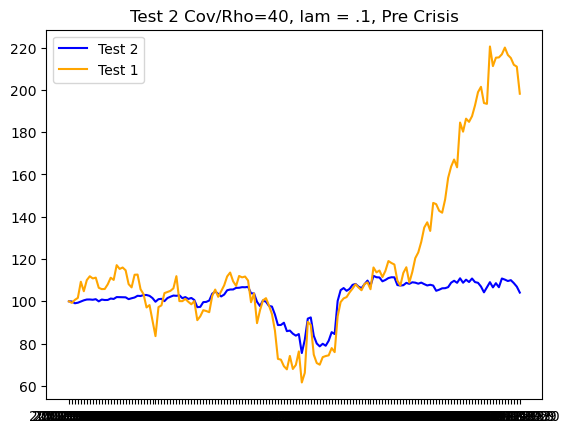

In [52]:
plt.plot(df.index[40:192], test2_40_40_lam1_pre_sub['Port Values'], color = 'blue', label ='Test 2')
plt.plot(df.index[40:192], test1_40_40_lam1_pre_sub['Port Values'], color = 'orange', label ='Test 1')
plt.title('Test 2 Cov/Rho=40, lam = .1, Pre Crisis')
plt.legend()
plt.show()


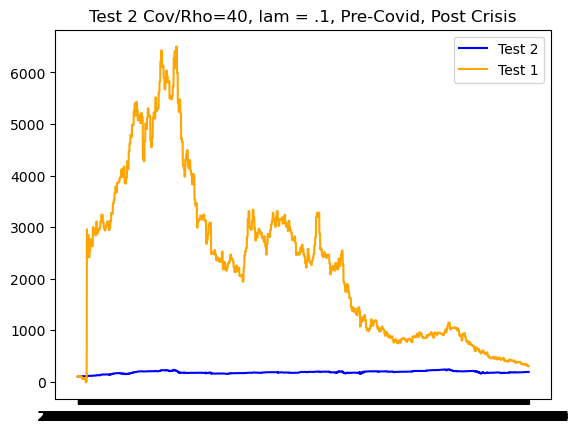

In [54]:

plt.plot(df.index[505+40:3254], test2_40_40_lam1_pre_cov['Port Values'], color = 'blue', label ='Test 2')
plt.plot(df.index[505+40:3254], test1_40_40_lam1_pre_cov['Port Values'], color = 'orange', label='Test 1')
plt.title('Test 2 Cov/Rho=40, lam = .1, Pre-Covid, Post Crisis')
plt.legend()
plt.show()

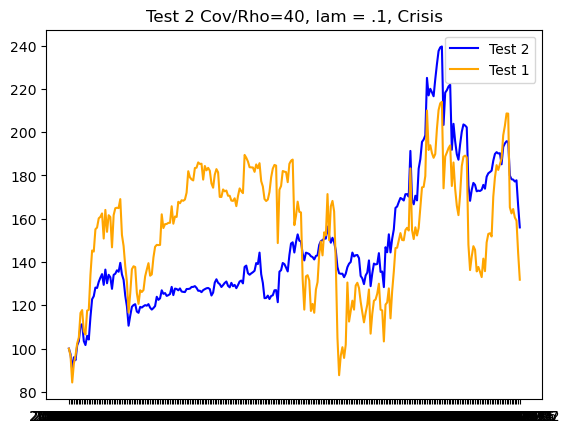

In [56]:
plt.plot(df.index[192+40:505], test2_40_40_lam1_sub['Port Values'], color = 'blue', label ='Test 2')
plt.plot(df.index[192+40:505], test1_40_40_lam1_sub['Port Values'], color = 'orange', label='Test 1')
plt.title('Test 2 Cov/Rho=40, lam = .1, Crisis')
plt.legend()
plt.show()

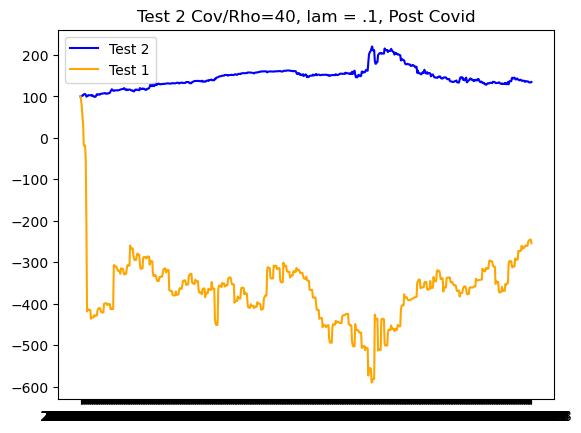

In [57]:
plt.plot(df.index[3296+40:], test2_40_40_lam1_post_cov['Port Values'], color = 'blue', label ='Test 2')
plt.plot(df.index[3296+40:], test1_40_40_lam1_post_cov['Port Values'], color = 'orange', label='Test 1')
plt.title('Test 2 Cov/Rho=40, lam = .1, Post Covid')
plt.legend()
plt.show()

In [860]:
test_1 = [test1_40_40_lam1,
test1_40_40_lam2,
test1_40_40_lam3,
test1_90_40_lam1,
test1_90_40_lam2,
test1_90_40_lam3,
test1_180_40_lam1,
test1_180_40_lam2,
test1_180_40_lam3,
test1_40_90_lam1,
test1_40_90_lam2,
test1_40_90_lam3,
test1_90_90_lam1,
test1_90_90_lam2,
test1_90_90_lam3,
test1_180_90_lam1,
test1_180_90_lam2,
test1_180_90_lam3,
test1_40_180_lam1,
test1_40_180_lam2,
test1_40_180_lam3,
test1_90_180_lam1,
test1_90_180_lam2,
test1_90_180_lam3,
test1_180_180_lam1,
test1_180_180_lam2,
test1_180_180_lam3]

test_2 = [test2_40_40_lam1,
test2_40_40_lam2,
test2_40_40_lam3,
test2_90_40_lam1,
test2_90_40_lam2,
test2_90_40_lam3,
test2_180_40_lam1,
test2_180_40_lam2,
test2_180_40_lam3,
test2_40_90_lam1,
test2_40_90_lam2,
test2_40_90_lam3,
test2_90_90_lam1,
test2_90_90_lam2,
test2_90_90_lam3,
test2_180_90_lam1,
test2_180_90_lam2,
test2_180_90_lam3,
test2_40_180_lam1,
test2_40_180_lam2,
test2_40_180_lam3,
test2_90_180_lam1,
test2_90_180_lam2,
test2_90_180_lam3,
test2_180_180_lam1,
test2_180_180_lam2,
test2_180_180_lam3]

cum_pnl_1 = []
arr_mean_return_1 = []
geo_mean_return_1 = []
max_drawdown_1 = []
vol_1 = []
sharpe_1 = []
skewness_1 = []
kurtosis_1= []
modified_VaR_1 = []
CVaR_1 = []
pct_changes_1 =[]

for x in test_1:
    cum_pnl = x['Port Values'][-1:].to_numpy()[0]
    cum_pnl_1.append(cum_pnl)
    pct_change = x['Port Values'].pct_change(1)[1:]
    pct_changes_1.append(pct_change)
    
    ar_mean = np.mean(pct_change)
    ar_mean = ar_mean*252
    arr_mean_return_1.append(ar_mean)

    geomean = 1
    for i in pct_change:
        geomean *= (1+i)
    if geomean < 0:
        geomean = 0
    else:
        geomean = (geomean ** (1/len(pct_change)))-1
    geomean = geomean*252
    geo_mean_return_1.append(geomean)


    priceMax = 0
    maxDrawDown = 0
    for count in range(len(x["Port Values"])):
        priceMax = max(priceMax, x["Port Values"][count])
        relMin = x["Port Values"][count+1:count+11].min()
        dist = priceMax - relMin
        maxDrawDown = max(maxDrawDown, dist)
        priceMax = 0
    max_drawdown_1.append(maxDrawDown)
    
    vol = np.std(pct_change)
    vol = vol*np.sqrt(252)
    vol_1.append(vol)
    
    sharpe = (ar_mean - df["RF"].mean()*252) / vol
    sharpe_1.append(sharpe)
    
    skewness = skew(pct_change)
    skewness_1.append(skewness)
    
    kurt = kurtosis(pct_change)
    kurtosis_1.append(kurt)
    
    a = .95
    y = pct_change
    y = sorted(y)
    VaR = y[len(y) - int(round(len(y)*a))]
    VaR
    modified_VaR_1.append(VaR)
    CVaR = np.mean(y[:len(y) - int(round(len(y)*a)) + 1])
    CVaR_1.append(CVaR)


In [861]:
test1_180_40_lam1[:2770].tail(15)

,Port Values,Daily Dollar Changes
2755,19.975947,-52.714233
2756,21.939524,1.963578
2757,20.790918,-1.148606
2758,36.399047,15.608129
2759,-149.757363,-186.156410
2760,2.451461,152.208824
2761,2.349867,-0.101594
2762,-6.596982,-8.946849
2763,-34.599172,-28.002190
2764,-286.204357,-251.605185


In [862]:
test_1_str= ["test1_40_40_lam1",
'test1_40_40_lam2',
'test1_40_40_lam3',
'test1_90_40_lam1',
'test1_90_40_lam2',
'test1_90_40_lam3',
'test1_180_40_lam1',
'test1_180_40_lam2',
'test1_180_40_lam3',
'test1_40_90_lam1',
'test1_40_90_lam2',
'test1_40_90_lam3',
'test1_90_90_lam1',
'test1_90_90_lam2',
'test1_90_90_lam3',
'test1_180_90_lam1',
'test1_180_90_lam2',
'test1_180_90_lam3',
'test1_40_180_lam1',
'test1_40_180_lam2',
'test1_40_180_lam3',
'test1_90_180_lam1',
'test1_90_180_lam2',
'test1_90_180_lam3',
'test1_180_180_lam1',
'test1_180_180_lam2',
'test1_180_180_lam3']

In [864]:
df_summary_1 = pd.DataFrame({'Test Param':test_1_str,'Cum PnL': cum_pnl_1,
                             'Arr Mean Return': arr_mean_return_1,
"Geo Mean Return": geo_mean_return_1,
"Max Drawdown" : max_drawdown_1,
"Vol" : vol_1,
"Sharpe": sharpe_1,
"Skewness": skewness_1,
"Kurtosis":kurtosis_1,
"VaR":modified_VaR_1,
"CVaR": CVaR_1})
#df_summary_1 = df_summary_1.set_index('Test Param')

In [865]:
df_summary_1

,Test Param,Cum PnL,Arr Mean Return,Geo Mean Return,Max Drawdown,Vol,Sharpe,Skewness,Kurtosis,VaR,CVaR
0,test1_40_40_lam1,229.719465,-0.842851,0.052573,116.427902,3.651002,-0.233098,-58.076442,3554.490583,-0.056066,-0.178563
1,test1_40_40_lam2,282.770608,0.130239,0.065708,58.745492,0.373486,0.326784,7.616888,238.516016,-0.023672,-0.050570
2,test1_40_40_lam3,129.535360,0.016524,0.016357,5.167949,0.018307,0.455273,1.422119,245.826551,-0.000457,-0.001527
3,test1_90_40_lam1,-184.501998,0.004274,0.000000,426.266333,1.883412,-0.002079,-34.233361,1897.779249,-0.064048,-0.146187
4,test1_90_40_lam2,278.250724,0.107901,0.065511,62.026315,0.291636,0.341903,0.748824,38.178841,-0.019514,-0.045223
5,test1_90_40_lam3,111.135556,0.006932,0.006758,7.554317,0.018545,-0.067857,-10.752754,807.785413,-0.000344,-0.001401
6,test1_180_40_lam1,-2514.383251,2.022624,0.000000,7945.170045,7.338066,0.274518,49.250842,2793.448941,-0.055165,-0.154521
7,test1_180_40_lam2,294.878988,0.133000,0.070847,89.580429,0.352003,0.354570,0.562797,47.817366,-0.020599,-0.052887
8,test1_180_40_lam3,106.139589,0.006960,0.003903,30.613887,0.079801,-0.015419,14.330904,693.246682,-0.000381,-0.003939
9,test1_40_90_lam1,147.971009,0.175390,0.025083,115.531107,0.546964,0.305686,0.196939,14.706728,-0.049700,-0.085191


In [866]:

cum_pnl_2 = []
arr_mean_return_2 = []
geo_mean_return_2 =[]
max_drawdown_2 = []
vol_2 = []
sharpe_2 = []
skewness_2 = []
kurtosis_2= []
modified_VaR_2 = []
CVaR_2 = []
pct_changes_2=[]

for x in test_2:
    cum_pnl = x['Port Values'][-1:].to_numpy()[0]
    cum_pnl_2.append(cum_pnl)
    
    pct_change = x['Port Values'].pct_change(1)[1:]
    pct_changes_2.append(pct_change)
    
    ar_mean = np.mean(pct_change)
    ar_mean = ar_mean*252
    arr_mean_return_2.append(ar_mean)

    geomean = 1
    for i in pct_change:
        geomean *= (1+i)
    geomean = geomean ** (1/len(pct_change))-1
    geomean= geomean*252
    geo_mean_return_2.append(geomean)


    priceMax = 0
    maxDrawDown = 0
    for count in range(len(x["Port Values"])):
        priceMax = max(priceMax, x["Port Values"][count])
        relMin = x["Port Values"][count+1:count+11].min()
        dist = priceMax - relMin
        maxDrawDown = max(maxDrawDown, dist)
        priceMax = 0
    max_drawdown_2.append(maxDrawDown)
    
    vol = np.std(pct_change)
    vol = vol*np.sqrt(252)
    vol_2.append(vol)
    
    sharpe = (ar_mean - df["RF"].mean()*252) / vol
    sharpe_2.append(sharpe)
    
    skewness = skew(pct_change)
    skewness_2.append(skewness)
    
    kurt = kurtosis(pct_change)
    kurtosis_2.append(kurt)
    
    a = .95
    y = pct_change
    y = sorted(y)
    VaR = y[len(y) - int(round(len(y)*a))]
    VaR
    modified_VaR_2.append(VaR)
    CVaR = np.mean(y[:len(y) - int(round(len(y)*a)) + 1])
    CVaR_2.append(CVaR)


In [867]:
test_2_str= ["test2_40_40_lam1",
'test2_40_40_lam2',
'test2_40_40_lam3',
'test2_90_40_lam1',
'test2_90_40_lam2',
'test2_90_40_lam3',
'test2_180_40_lam1',
'test2_180_40_lam2',
'test2_180_40_lam3',
'test2_40_90_lam1',
'test2_40_90_lam2',
'test2_40_90_lam3',
'test2_90_90_lam1',
'test2_90_90_lam2',
'test2_90_90_lam3',
'test2_180_90_lam1',
'test2_180_90_lam2',
'test2_180_90_lam3',
'test2_40_180_lam1',
'test2_40_180_lam2',
'test2_40_180_lam3',
'test2_90_180_lam1',
'test2_90_180_lam2',
'test2_90_180_lam3',
'test2_180_180_lam1',
'test2_180_180_lam2',
'test2_180_180_lam3']

In [868]:
df_summary_2 = pd.DataFrame({'Test Param':test_2_str, 
                             'Cum PnL':cum_pnl_2,
                             'Arr Mean Return': arr_mean_return_2,
"Geo Mean Return": geo_mean_return_2,
"Max Drawdown" : max_drawdown_2,
"Vol" : vol_2,
"Sharpe": sharpe_2,
"Skewness": skewness_2,
"Kurtosis":kurtosis_2,
"VaR":modified_VaR_2,
"CVaR": CVaR_2})

#df_summary_2 = df_summary_2.set_index('Test Param')

In [869]:
df_summary_2

,Test Param,Cum PnL,Arr Mean Return,Geo Mean Return,Max Drawdown,Vol,Sharpe,Skewness,Kurtosis,VaR,CVaR
0,test2_40_40_lam1,390.919090,0.122634,0.086185,77.061911,0.267245,0.428236,-1.222176,45.803452,-0.016215,-0.040197
1,test2_40_40_lam2,279.166430,0.090840,0.064897,50.545635,0.226963,0.364155,-0.407030,32.360732,-0.016936,-0.034884
2,test2_40_40_lam3,128.939662,0.016209,0.016066,4.952370,0.016928,0.473707,2.364606,229.036199,-0.000316,-0.001053
3,test2_90_40_lam1,467.799956,0.140992,0.098776,92.128306,0.287602,0.461754,-1.010759,48.661514,-0.016904,-0.041855
4,test2_90_40_lam2,209.956638,0.078771,0.047481,54.110680,0.250063,0.282254,0.326899,34.332610,-0.018269,-0.038406
5,test2_90_40_lam3,110.580332,0.006515,0.006438,6.254858,0.012364,-0.135459,-32.210627,1660.321239,-0.000315,-0.000912
6,test2_180_40_lam1,427.984127,0.142380,0.095258,93.290814,0.303406,0.442281,-1.133308,47.162710,-0.018713,-0.045052
7,test2_180_40_lam2,240.967374,0.097071,0.057618,58.666568,0.280648,0.316701,0.269484,31.838254,-0.020743,-0.043352
8,test2_180_40_lam3,101.650725,0.003145,0.001072,22.673277,0.065381,-0.077166,12.903916,635.765812,-0.000351,-0.003312
9,test2_40_90_lam1,266.718764,0.097468,0.062801,85.406899,0.261608,0.341266,-0.721957,35.094811,-0.018780,-0.040037


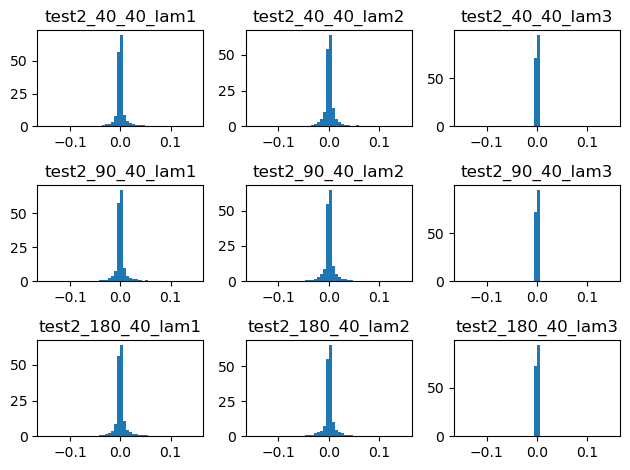

In [822]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(3 , 3)

ax1.hist(pct_changes_2[0], bins = 50, range = (-.15,.15) ,density = True)
ax1.set_title('test2_40_40_lam1')

ax2.hist(pct_changes_2[1], bins = 50, range = (-.15,.15) ,density = True)
ax2.set_title('test2_40_40_lam2')

ax3.hist(pct_changes_2[2], bins = 50, range = (-.15,.15) ,density = True)
ax3.set_title('test2_40_40_lam3')

ax4.hist(pct_changes_2[3], bins = 50, range = (-.15,.15) ,density = True)
ax4.set_title('test2_90_40_lam1')

ax5.hist(pct_changes_2[4], bins = 50, range = (-.15,.15) ,density = True)
ax5.set_title('test2_90_40_lam2')

ax6.hist(pct_changes_2[5], bins = 50, range = (-.15,.15) ,density = True)
ax6.set_title('test2_90_40_lam3')

ax7.hist(pct_changes_2[6], bins = 50, range = (-.15,.15) ,density = True)
ax7.set_title('test2_180_40_lam1')

ax8.hist(pct_changes_2[7], bins = 50, range = (-.15,.15) ,density = True)
ax8.set_title('test2_180_40_lam2')

ax9.hist(pct_changes_2[8], bins = 50, range = (-.15,.15) ,density = True)
ax9.set_title('test2_180_40_lam3')

fig.tight_layout()
plt.show()

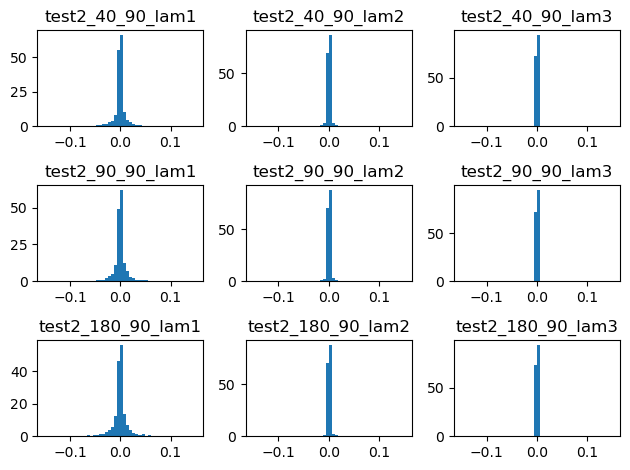

In [821]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(3 , 3)

ax1.hist(pct_changes_2[9], bins = 50, range = (-.15,.15) ,density = True)
ax1.set_title('test2_40_90_lam1')

ax2.hist(pct_changes_2[10], bins = 50, range = (-.15,.15) ,density = True)
ax2.set_title('test2_40_90_lam2')

ax3.hist(pct_changes_2[11], bins = 50, range = (-.15,.15) ,density = True)
ax3.set_title('test2_40_90_lam3')

ax4.hist(pct_changes_2[12], bins = 50, range = (-.15,.15) ,density = True)
ax4.set_title('test2_90_90_lam1')

ax5.hist(pct_changes_2[13], bins = 50, range = (-.15,.15) ,density = True)
ax5.set_title('test2_90_90_lam2')

ax6.hist(pct_changes_2[14], bins = 50, range = (-.15,.15) ,density = True)
ax6.set_title('test2_90_90_lam3')

ax7.hist(pct_changes_2[15], bins = 50, range = (-.15,.15) ,density = True)
ax7.set_title('test2_180_90_lam1')

ax8.hist(pct_changes_2[16], bins = 50, range = (-.15,.15) ,density = True)
ax8.set_title('test2_180_90_lam2')

ax9.hist(pct_changes_2[17], bins = 50, range = (-.15,.15) ,density = True)
ax9.set_title('test2_180_90_lam3')

fig.tight_layout()
plt.show()

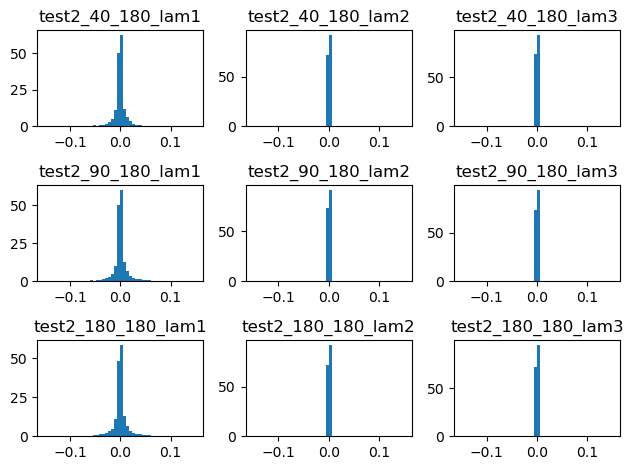

In [823]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9)) = plt.subplots(3 , 3)

ax1.hist(pct_changes_2[18], bins = 50, range = (-.15,.15) ,density = True)
ax1.set_title('test2_40_180_lam1')

ax2.hist(pct_changes_2[19], bins = 50, range = (-.15,.15) ,density = True)
ax2.set_title('test2_40_180_lam2')

ax3.hist(pct_changes_2[20], bins = 50, range = (-.15,.15) ,density = True)
ax3.set_title('test2_40_180_lam3')

ax4.hist(pct_changes_2[21], bins = 50, range = (-.15,.15) ,density = True)
ax4.set_title('test2_90_180_lam1')

ax5.hist(pct_changes_2[22], bins = 50, range = (-.15,.15) ,density = True)
ax5.set_title('test2_90_180_lam2')

ax6.hist(pct_changes_2[23], bins = 50, range = (-.15,.15) ,density = True)
ax6.set_title('test2_90_180_lam3')

ax7.hist(pct_changes_2[24], bins = 50, range = (-.15,.15) ,density = True)
ax7.set_title('test2_180_180_lam1')

ax8.hist(pct_changes_2[25], bins = 50, range = (-.15,.15) ,density = True)
ax8.set_title('test2_180_180_lam2')

ax9.hist(pct_changes_2[26], bins = 50, range = (-.15,.15) ,density = True)
ax9.set_title('test2_180_180_lam3')

fig.tight_layout()
plt.show()

In [310]:
pct_change

1       0.000473
2       0.000518
3       0.000108
4       0.000443
5       0.000441
          ...   
3843   -0.000085
3844    0.000152
3845    0.000319
3846   -0.000020
3847    0.000238
Name: Port Values, Length: 3847, dtype: float64

In [321]:

return_df['SPY'][40:]
#return_df['SPY'][90:]
#return_df['SPY'][180:]

2007-04-27   -0.000802
2007-04-30   -0.008327
2007-05-01    0.002559
2007-05-02    0.005834
2007-05-03    0.005402
                ...   
2023-02-22   -0.001379
2023-02-23    0.005305
2023-02-24   -0.010740
2023-02-27    0.003400
2023-02-28   -0.003703
Name: SPY, Length: 3988, dtype: float64

In [724]:
port_val = 100
port_vals_40 =[]
for x in return_df['SPY'][40:]:
    port_val = port_val*(1+x)
    port_vals_40.append(port_val)
port_val

257.4138550661941

In [725]:
port_val = 100
port_vals_90 =[]
for x in return_df['SPY'][90:]:
    port_val = port_val*(1+x)
    port_vals_90.append(port_val)
port_val

250.84787126832978

In [726]:
port_val = 100
port_vals_180 =[]
for x in return_df['SPY'][180:]:
    port_val = port_val*(1+x)
    port_vals_180.append(port_val)
port_val

259.79899565668364

In [727]:
df.index[0:]

Index(['2007-03-01', '2007-03-02', '2007-03-05', '2007-03-06', '2007-03-07',
       '2007-03-08', '2007-03-09', '2007-03-12', '2007-03-13', '2007-03-14',
       ...
       '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17', '2023-02-21',
       '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27', '2023-02-28'],
      dtype='object', name='Date', length=4028)

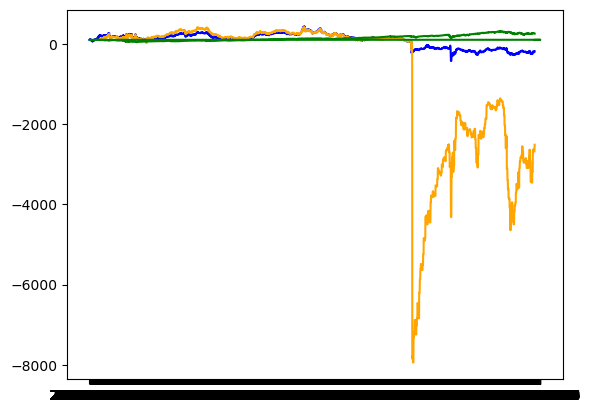

In [728]:
plt.plot(df.index[90:], test1_90_40_lam1['Port Values'], color = 'blue')
plt.plot(df.index[180:], test1_180_40_lam1['Port Values'], color ='orange')
plt.plot(df.index[40:], port_vals_40, color = 'green')
plt.show()

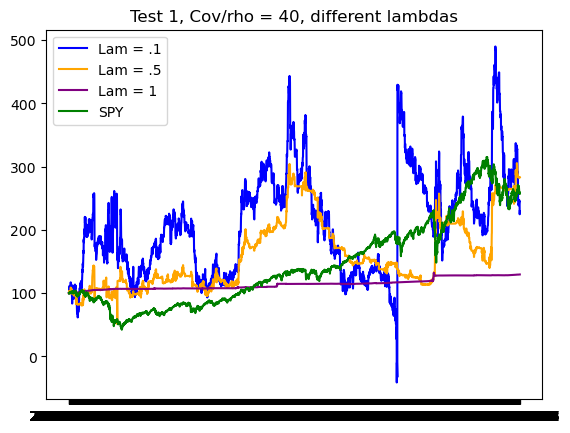

In [829]:
plt.plot(df.index[40:], test1_40_40_lam1['Port Values'], color = 'blue', label ='Lam = .1')
plt.plot(df.index[40:], test1_40_40_lam2['Port Values'], color ='orange', label ='Lam = .5')
plt.plot(df.index[40:], test1_40_40_lam3['Port Values'], color ='purple', label ='Lam = 1')
plt.plot(df.index[40:], port_vals_40, color = 'green', label ='SPY')
plt.title('Test 1, Cov/rho = 40, different lambdas')
plt.legend()
plt.show()

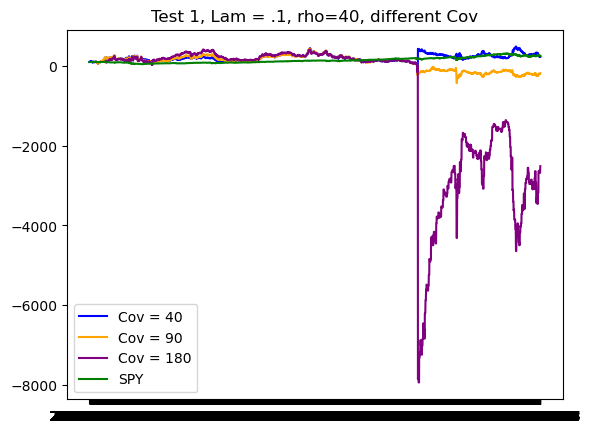

In [832]:
plt.plot(df.index[40:], test1_40_40_lam1['Port Values'], color = 'blue', label ='Cov = 40')
plt.plot(df.index[90:], test1_90_40_lam1['Port Values'], color ='orange', label ='Cov = 90')
plt.plot(df.index[180:], test1_180_40_lam1['Port Values'], color ='purple', label ='Cov = 180')
plt.plot(df.index[40:], port_vals_40, color = 'green', label ='SPY')
plt.title('Test 1, Lam = .1, rho=40, different Cov')
plt.legend()
plt.show()

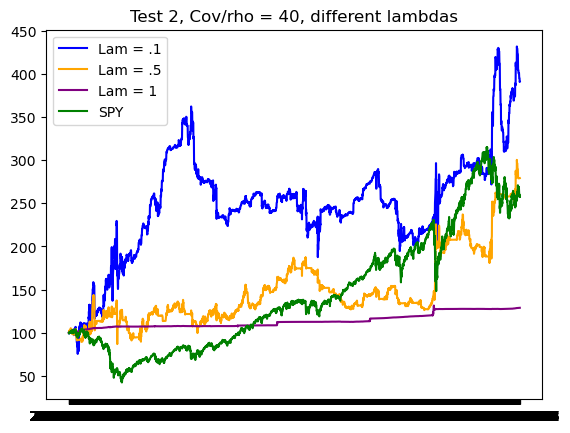

In [833]:
plt.plot(df.index[40:], test2_40_40_lam1['Port Values'], color = 'blue', label ='Lam = .1')
plt.plot(df.index[40:], test2_40_40_lam2['Port Values'], color ='orange', label ='Lam = .5')
plt.plot(df.index[40:], test2_40_40_lam3['Port Values'], color ='purple', label ='Lam = 1')
plt.plot(df.index[40:], port_vals_40, color = 'green', label ='SPY')
plt.title('Test 2, Cov/rho = 40, different lambdas')
plt.legend()
plt.show()

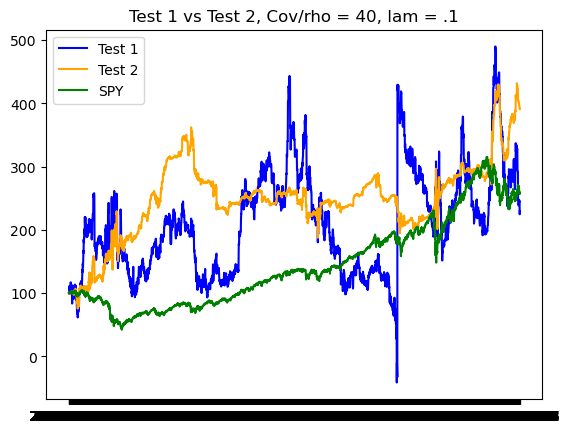

In [834]:
plt.plot(df.index[40:], test1_40_40_lam1['Port Values'], color = 'blue', label = 'Test 1')
plt.plot(df.index[40:], test2_40_40_lam1['Port Values'], color ='orange', label = 'Test 2')
plt.plot(df.index[40:], port_vals_40, color = 'green', label = 'SPY')
plt.title('Test 1 vs Test 2, Cov/rho = 40, lam = .1')
plt.legend()
plt.show()

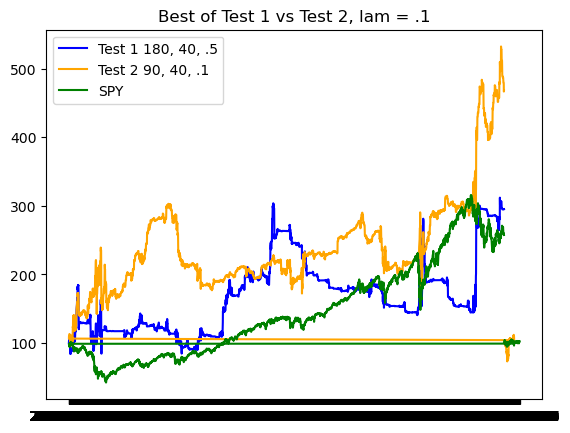

In [835]:
plt.plot(df.index[180:], test1_180_40_lam2['Port Values'], color = 'blue', label = 'Test 1 180, 40, .5')
plt.plot(df.index[90:], test2_90_40_lam1['Port Values'], color ='orange', label = 'Test 2 90, 40, .1')
plt.plot(df.index[40:], port_vals_40, color = 'green', label = 'SPY')
plt.title('Best of Test 1 vs Test 2, lam = .1')
plt.legend()
plt.show()

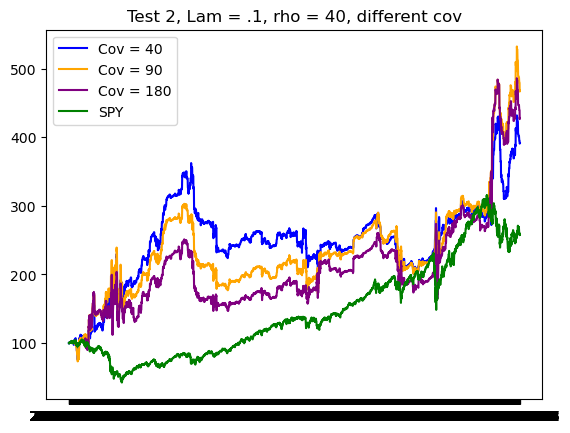

In [836]:
plt.plot(df.index[40:], test2_40_40_lam1['Port Values'], color = 'blue', label = 'Cov = 40')
plt.plot(df.index[90:], test2_90_40_lam1['Port Values'], color ='orange', label = 'Cov = 90')
plt.plot(df.index[180:], test2_180_40_lam1['Port Values'], color ='purple', label = 'Cov = 180')
plt.plot(df.index[40:], port_vals_40, color = 'green', label = 'SPY')
plt.title('Test 2, Lam = .1, rho = 40, different cov')
plt.legend()
plt.show()

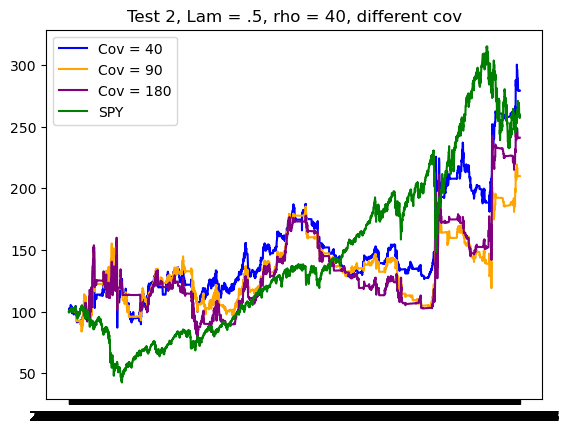

In [837]:
plt.plot(df.index[40:], test2_40_40_lam2['Port Values'], color = 'blue', label = 'Cov = 40')
plt.plot(df.index[90:], test2_90_40_lam2['Port Values'], color ='orange', label = 'Cov = 90')
plt.plot(df.index[180:], test2_180_40_lam2['Port Values'], color ='purple', label = 'Cov = 180')
plt.plot(df.index[40:], port_vals_40, color = 'green', label = 'SPY')
plt.title('Test 2, Lam = .5, rho = 40, different cov')
plt.legend()
plt.show()

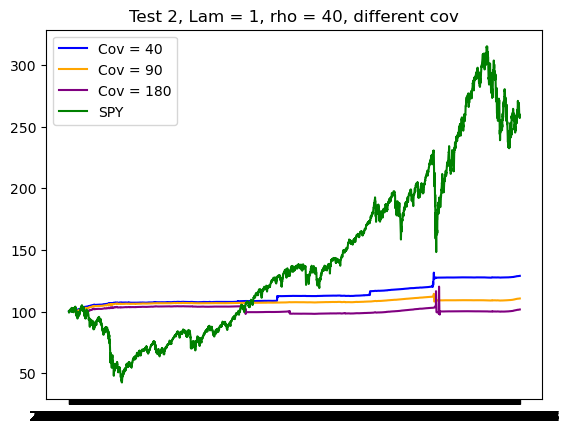

In [838]:
plt.plot(df.index[40:], test2_40_40_lam3['Port Values'], color = 'blue', label = 'Cov = 40')
plt.plot(df.index[90:], test2_90_40_lam3['Port Values'], color ='orange', label = 'Cov = 90')
plt.plot(df.index[180:], test2_180_40_lam3['Port Values'], color ='purple', label = 'Cov = 180')
plt.plot(df.index[40:], port_vals_40, color = 'green', label = 'SPY')
plt.title('Test 2, Lam = 1, rho = 40, different cov')
plt.legend()
plt.show()

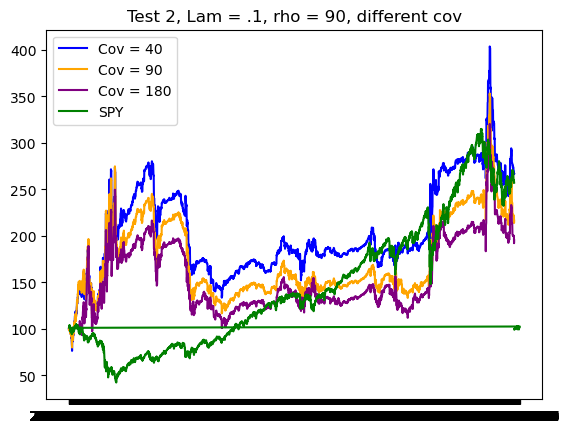

In [841]:
plt.plot(df.index[90:], test2_40_90_lam1['Port Values'], color = 'blue', label = 'Cov = 40')
plt.plot(df.index[90:], test2_90_90_lam1['Port Values'], color ='orange', label = 'Cov = 90')
plt.plot(df.index[180:], test2_180_90_lam1['Port Values'], color ='purple', label = 'Cov = 180')
plt.plot(df.index[40:], port_vals_40, color = 'green', label = 'SPY')
plt.title('Test 2, Lam = .1, rho = 90, different cov')Z
plt.legend()
plt.show()

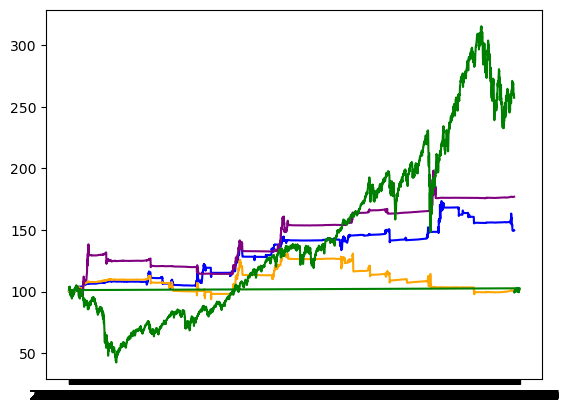

In [740]:
plt.plot(df.index[90:], test2_40_90_lam2['Port Values'], color = 'blue')
plt.plot(df.index[90:], test2_90_90_lam2['Port Values'], color ='orange')
plt.plot(df.index[180:], test2_180_90_lam2['Port Values'], color ='purple')
plt.plot(df.index[40:], port_vals_40, color = 'green')
plt.show()

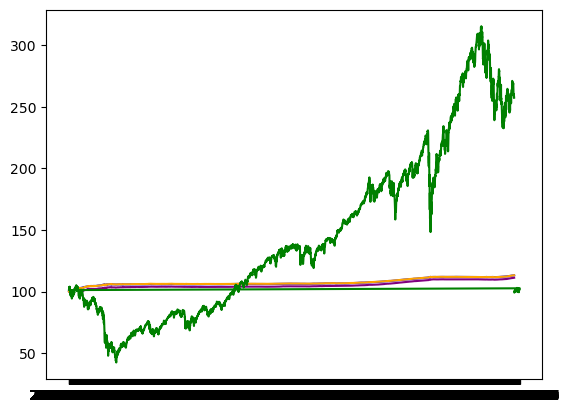

In [741]:
plt.plot(df.index[90:], test2_40_90_lam3['Port Values'], color = 'blue')
plt.plot(df.index[90:], test2_90_90_lam3['Port Values'], color ='orange')
plt.plot(df.index[180:], test2_180_90_lam3['Port Values'], color ='purple')
plt.plot(df.index[40:], port_vals_40, color = 'green')
plt.show()

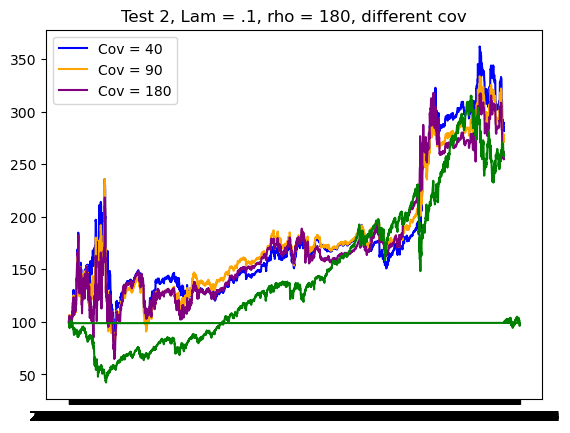

In [842]:
plt.plot(df.index[180:], test2_40_180_lam1['Port Values'], color = 'blue', label = 'Cov = 40')
plt.plot(df.index[180:], test2_90_180_lam1['Port Values'], color ='orange', label = 'Cov = 90')
plt.plot(df.index[180:], test2_180_180_lam1['Port Values'], color ='purple', label = 'Cov = 180')
plt.plot(df.index[40:], port_vals_40, color = 'green')
plt.title('Test 2, Lam = .1, rho = 180, different cov')
plt.legend()
plt.show()

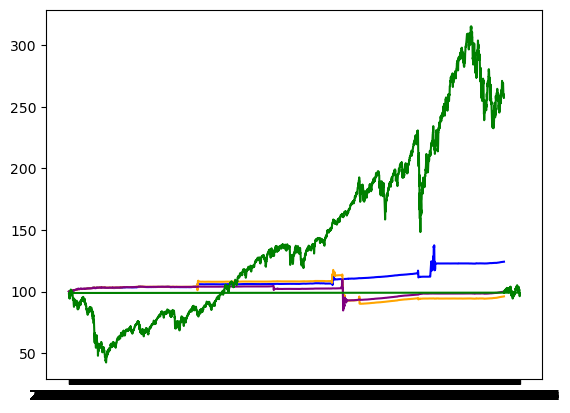

In [743]:
plt.plot(df.index[180:], test2_40_180_lam2['Port Values'], color = 'blue')
plt.plot(df.index[180:], test2_90_180_lam2['Port Values'], color ='orange')
plt.plot(df.index[180:], test2_180_180_lam2['Port Values'], color ='purple')
plt.plot(df.index[40:], port_vals_40, color = 'green')
plt.show()

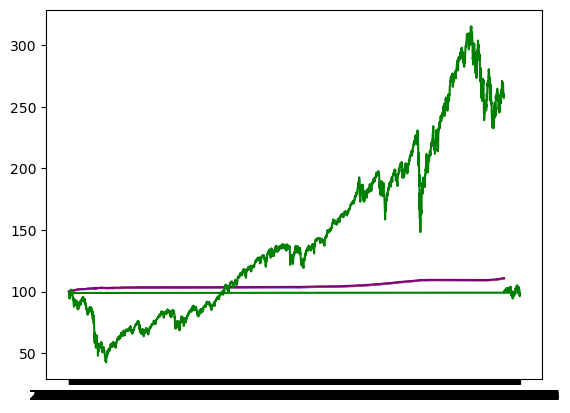

In [744]:
plt.plot(df.index[180:], test2_40_180_lam3['Port Values'], color = 'blue')
plt.plot(df.index[180:], test2_90_180_lam3['Port Values'], color ='orange')
plt.plot(df.index[180:], test2_180_180_lam3['Port Values'], color ='purple')
plt.plot(df.index[40:], port_vals_40, color = 'green')
plt.show()

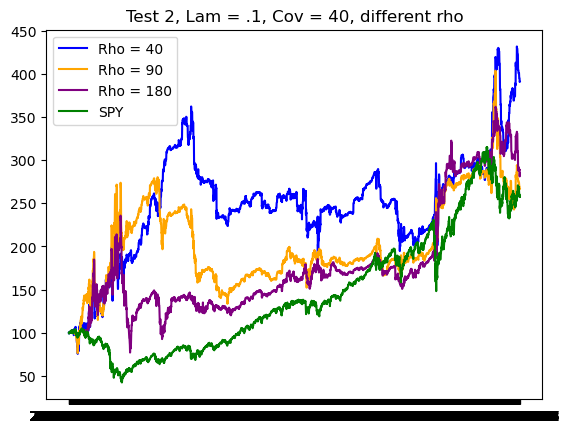

In [848]:
plt.plot(df.index[40:], test2_40_40_lam1['Port Values'], color = 'blue', label = 'Rho = 40')
plt.plot(df.index[90:], test2_40_90_lam1['Port Values'], color ='orange', label = 'Rho = 90')
plt.plot(df.index[180:], test2_40_180_lam1['Port Values'], color ='purple', label = 'Rho = 180')
plt.plot(df.index[40:], port_vals_40, color = 'green', label = 'SPY')
plt.title('Test 2, Lam = .1, Cov = 40, different rho')
plt.legend()
plt.show()

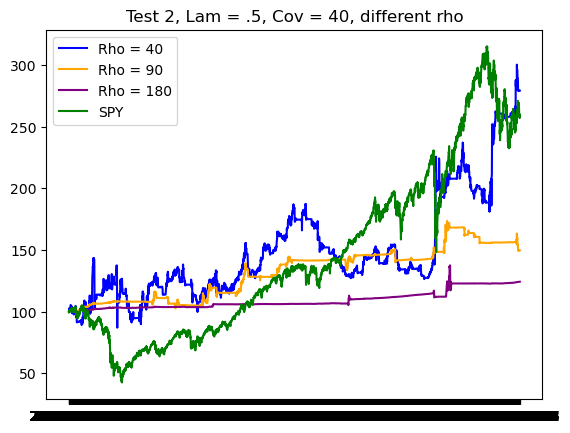

In [849]:
plt.plot(df.index[40:], test2_40_40_lam2['Port Values'], color = 'blue', label = 'Rho = 40')
plt.plot(df.index[90:], test2_40_90_lam2['Port Values'], color ='orange', label = 'Rho = 90')
plt.plot(df.index[180:], test2_40_180_lam2['Port Values'], color ='purple', label = 'Rho = 180')
plt.plot(df.index[40:], port_vals_40, color = 'green', label = 'SPY')
plt.title('Test 2, Lam = .5, Cov = 40, different rho')
plt.legend()
plt.show()

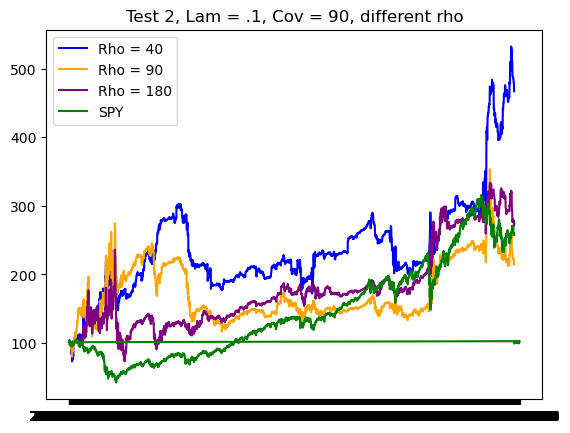

In [850]:
plt.plot(df.index[90:], test2_90_40_lam1['Port Values'], color = 'blue',label = 'Rho = 40')
plt.plot(df.index[90:], test2_90_90_lam1['Port Values'], color ='orange',label = 'Rho = 90')
plt.plot(df.index[180:], test2_90_180_lam1['Port Values'], color ='purple',label = 'Rho = 180')
plt.plot(df.index[40:], port_vals_40, color = 'green', label = 'SPY')
plt.title('Test 2, Lam = .1, Cov = 90, different rho')
plt.legend()
plt.show()

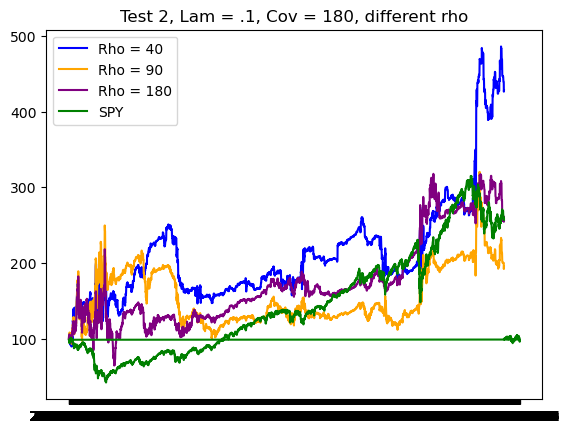

In [851]:
plt.plot(df.index[180:], test2_180_40_lam1['Port Values'], color = 'blue',label = 'Rho = 40')
plt.plot(df.index[180:], test2_180_90_lam1['Port Values'], color ='orange',label = 'Rho = 90')
plt.plot(df.index[180:], test2_180_180_lam1['Port Values'], color ='purple',label = 'Rho = 180')
plt.plot(df.index[40:], port_vals_40, color = 'green', label = 'SPY')
plt.title('Test 2, Lam = .1, Cov = 180, different rho')
plt.legend()
plt.show()